# Imbalanced data  

Also read the following on `weights`:  
* [machinelearningmastery.com](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/)  
* [stackoverflow.com](https://stackoverflow.com/questions/67868420/xgboost-for-multiclassification-and-imbalanced-data)

The XGBoost algorithm is effective for a wide range of regression and classification predictive modeling problems.  

It is an efficient implementation of the stochastic gradient boosting algorithm and offers a range of hyperparameters that give fine-grained control over the model training procedure. Although the algorithm performs well in general, even on `imbalanced classification` datasets, it offers a way to tune the training algorithm to pay more attention to misclassification of the minority class for datasets with a skewed class distribution.  

This modified version of XGBoost is referred to as **Class Weighted XGBoost** or **Cost-Sensitive XGBoost** and can offer better performance on binary classification problems with a **severe class imbalance**.  

In this tutorial, you will discover weighted XGBoost for imbalanced classification.  

After completing this tutorial, you will know:  

* How gradient boosting works from a high level and how to develop an XGBoost model for classification.  
* **How the XGBoost training algorithm can be modified to weight error gradients proportional to positive class importance during training.**  
* How to configure the positive class weight for the XGBoost training algorithm and how to grid search different configurations.  

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train_df['class'] #provide your own target name
)

xgb_classifier.fit(X, y, sample_weight=sample_weights)

We can use the [make_classification()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) scikit-learn function to define a synthetic imbalanced two-class classification dataset. We will generate 10,000 examples with an approximate 1:100 minority to majority class ratio.

In [1]:
# define dataset
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0, 
                            n_clusters_per_class=2, weights=[0.99], flip_y=0, 
                            random_state=7)

In [39]:
X[:, 0]

array([ 0.22084779, -3.15439532, -0.58175008, ..., -1.54290254,
       -0.67793673,  0.43013672])

In [40]:
X

array([[ 0.22084779,  2.53737202],
       [-3.15439532, -1.37418674],
       [-0.58175008, -0.04926179],
       ...,
       [-1.54290254,  0.4885024 ],
       [-0.67793673, -0.92557504],
       [ 0.43013672, -0.31590203]])

[0 0 0 ... 0 0 0]
[9900  100]


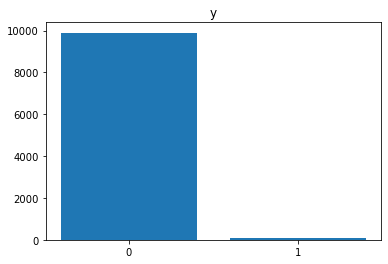

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

print(y)
print(np.bincount(y))
plt.bar(['0', '1'], (np.bincount(y)))
plt.title('y');

In [42]:
result = np.bincount(y)
result[1] / result[0]

0.010101010101010102

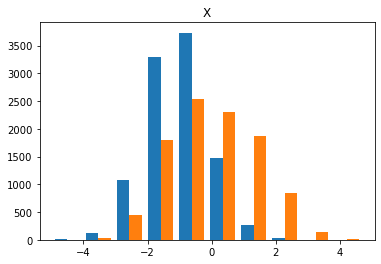

In [43]:
plt.hist(X); plt.title('X');

In [3]:
from collections import Counter

Counter(y)

Counter({0: 9900, 1: 100})

Counter({0: 9900, 1: 100})


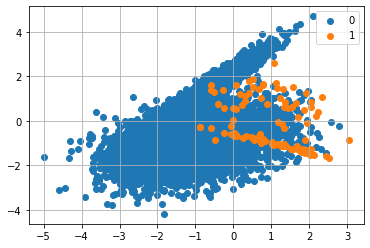

In [4]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=7)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend(); plt.grid(True)

# Weighted XGBoost for Class Imbalance  

Although the XGBoost algorithm performs well for a wide range of challenging problems, it offers a large number of hyperparameters, many of which require tuning in order to get the most out of the algorithm on a given dataset.  

The implementation provides a hyperparameter designed to tune the behavior of the algorithm for imbalanced classification problems; this is the **scale_pos_weight** hyperparameter.  

By default, the scale_pos_weight hyperparameter is set to the value of 1.0 and has the effect of weighing the balance of positive examples, relative to negative examples when boosting decision trees. For an imbalanced binary classification dataset, the negative class refers to the majority class (class 0) and the positive class refers to the minority class (class 1).  

XGBoost is trained to minimize a loss function and the “gradient” in gradient boosting refers to the steepness of this loss function, e.g. the amount of error. A small gradient means a small error and, in turn, a small change to the model to correct the error. A large error gradient during training in turn results in a large correction.   

* **Small Gradient**: Small error or correction to the model.  
* **Large Gradient**: Large error or correction to the model.  
Gradients are used as the basis for fitting subsequent trees added to boost or correct errors made by the existing state of the ensemble of decision trees.  

The scale_pos_weight value is used to scale the gradient for the positive class.  

This has the effect of scaling errors made by the model during training on the positive class and encourages the model to over-correct them. In turn, this can help the model achieve better performance when making predictions on the positive class. Pushed too far, it may result in the model overfitting the positive class at the cost of worse performance on the negative class or both classes.  

As such, the scale_pos_weight can be used to train a class-weighted or cost-sensitive version of XGBoost for imbalanced classification.  

A sensible default value to set for the scale_pos_weight hyperparameter is the inverse of the class distribution. For example, for a dataset with a 1 to 100 ratio for examples in the minority to majority classes, the scale_pos_weight can be set to 100. This will give classification errors made by the model on the minority class (positive class) 100 times more impact, and in turn, 100 times more correction than errors made on the majority class.  

## Baseline  

scale_pos_weight=1

In [5]:
# k-fold cross-validation 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from numpy import where
import warnings
import pandas as pd

warnings.simplefilter('ignore')

# generate dataset
X, y = make_classification(n_samples=10000, n_features=12, n_redundant=0,
	n_clusters_per_class=2, weights=[0.99], flip_y=0, random_state=7)

results = []
df_result = pd.DataFrame()

xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', scale_pos_weight=10,
                    learning_rate=0.01, n_estimators=200, random_state=2, eval_metric='auc',
                    n_jobs=-1)
scores = cross_val_score(xgb, X, y, scoring='roc_auc', cv=5)
results.append(scores)
print(results)
print(np.mean(results))

/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[array([0.89799242, 0.94906566, 0.89539141, 0.96056818, 0.96294192])]
0.9331919191919191


## Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        eval_metric='auc',random_state=2, use_label_encoder=False)
    
    # https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/ 
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, scoring='roc_auc', cv=kfold, n_iter=20, n_jobs=-1, random_state=2)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, scoring='roc_auc', cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

    print(xgb)

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        eval_metric='auc',random_state=2, use_label_encoder=False, 
                        params=best_params)
    print(xgb)
    xgb.fit(X,y)
    y_pred = xgb.predict(X)
    print(roc_auc_score(y_pred, y))

    best_params['max_depth'] = 1
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        eval_metric='auc',random_state=2, use_label_encoder=False, 
                        params=best_params)
    print(xgb)

Best params: {'learning_rate': 0.01, 'n_estimators': 200, 'scale_pos_weight': 10}  
Best score: `0.94446`

### Randomized grid search

In [20]:
grid_search(params={'scale_pos_weight':[1, 10], 
                    'learning_rate':[0.01, 0.05],
                    'n_estimators':[100]
                    },
            random=True)

Best params: {'scale_pos_weight': 10, 'n_estimators': 100, 'learning_rate': 0.05}
Best score: 0.94168
XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable

In [8]:
grid_search(params={'scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000], 
                    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
                    'n_estimators':[100, 200, 300, 400, 800, 1000]
                    },
            random=True)

/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/oliverdreger/opt/anaconda3/envs/dcr/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is d

KeyboardInterrupt: 

### Total grid search

In [ ]:
grid_search(params={'scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000], 
                    'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
                    'n_estimators':[100, 200, 300, 400, 800, 1000]
                    },
            random=False)

In [108]:
grid_search(params={'scale_pos_weight':[10], 
                    'learning_rate':[0.01],
                    'n_estimators':[1000]
                    },
            random=False)

Best params: {'learning_rate': 0.01, 'n_estimators': 1000, 'scale_pos_weight': 10}
Best score: 0.94179


In [109]:
grid_search(params={'scale_pos_weight':[10], 
                    'learning_rate':[0.01],
                    'n_estimators':[200]
                    },
            random=False)

Best params: {'learning_rate': 0.01, 'n_estimators': 200, 'scale_pos_weight': 10}
Best score: 0.93806
